In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os
import glob

In [3]:
import os
for dirname, _, filenames in os.walk('E:/Projects/VOC2007'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

E:/Projects/VOC2007\labels.txt
E:/Projects/VOC2007\Annotations\car_0.xml
E:/Projects/VOC2007\Annotations\car_1.xml
E:/Projects/VOC2007\Annotations\car_10.xml
E:/Projects/VOC2007\Annotations\car_100.xml
E:/Projects/VOC2007\Annotations\car_101.xml
E:/Projects/VOC2007\Annotations\car_102.xml
E:/Projects/VOC2007\Annotations\car_103.xml
E:/Projects/VOC2007\Annotations\car_104.xml
E:/Projects/VOC2007\Annotations\car_105.xml
E:/Projects/VOC2007\Annotations\car_106.xml
E:/Projects/VOC2007\Annotations\car_107.xml
E:/Projects/VOC2007\Annotations\car_108.xml
E:/Projects/VOC2007\Annotations\car_109.xml
E:/Projects/VOC2007\Annotations\car_11.xml
E:/Projects/VOC2007\Annotations\car_110.xml
E:/Projects/VOC2007\Annotations\car_111.xml
E:/Projects/VOC2007\Annotations\car_112.xml
E:/Projects/VOC2007\Annotations\car_113.xml
E:/Projects/VOC2007\Annotations\car_114.xml
E:/Projects/VOC2007\Annotations\car_115.xml
E:/Projects/VOC2007\Annotations\car_116.xml
E:/Projects/VOC2007\Annotations\car_117.xml
E:/Proj

In [5]:
IMAGE_SIZE = 200

In [6]:
import glob
img_dir = "E:/Projects/VOC2007/JPEGImages"
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
files.sort() 
X=[]
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X.append(np.array(img))
    

In [7]:
from lxml import etree
def resizeannotation(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]


In [8]:
path = 'E:/Projects/VOC2007/Annotations'
text_files = ['E:/Projects/VOC2007/Annotations/'+f for f in sorted(os.listdir(path))]
y=[]
for i in text_files:
    y.append(resizeannotation(i))

In [11]:
np.array(X).shape

(669, 200, 200, 3)

In [12]:
np.array(y).shape

(669, 4)

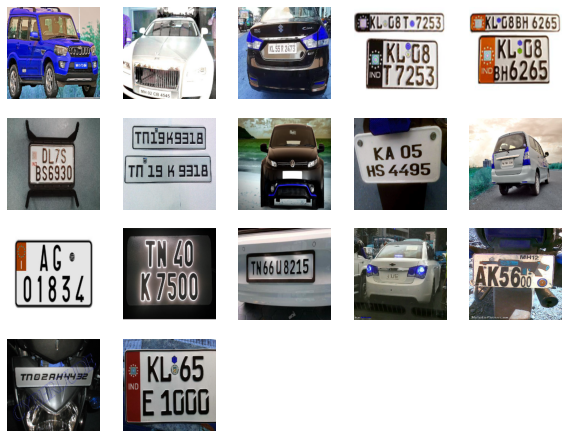

In [13]:
plt.figure(figsize=(10,20))
for i in range(0,17) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    plt.imshow(X[i])

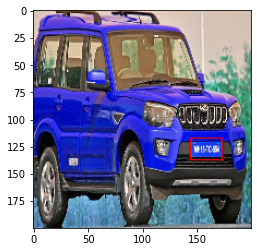

In [14]:
image = cv2.rectangle(X[0],(y[0][0],y[0][1]),(y[0][2],y[0][3]),(255, 0, 0))
plt.imshow(image)
plt.show()

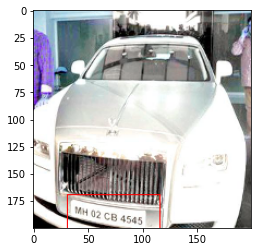

In [15]:
image = cv2.rectangle(X[1],(y[1][0],y[1][1]),(y[1][2],y[1][3]),(255, 0, 0))
plt.imshow(image)
plt.show()

In [16]:
X=np.array(X)
y=np.array(y)

In [17]:
X = X / 255
y = y / 255

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)
X_train1 = np.array(X_train)
y_train1 = np.array(y_train)
X_test1 = np.array(X_test)
y_test1 = np.array(y_test)
X_val1 = np.array(X_val)
y_val1 = np.array(y_val)

In [23]:
import keras
from keras.models import Sequential

from keras.layers import Dense, Flatten

from keras.applications.vgg16 import VGG16

In [26]:
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2359424   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 17,099,140
Trainable params: 2,384,452
Non-trainable params: 14,714,688
____________________________________

In [27]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])


In [ ]:
train = model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=40, batch_size=32, verbose=1)


In [ ]:
model.save('my_model.h5', overwrite=True) 
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()
plot_scores(train)

In [29]:
model = keras.models.load_model('my_model.h5')
scores = model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 85.07%


In [30]:
test_loss, test_accuracy = model.evaluate(X_test1, y_test1,steps=int(100))

print("Test results \n Loss:",test_loss,'\n Accuracy',test_accuracy)


 67/100 [===================>..........] - 40s 603ms/step - loss: 0.0073 - accuracy: 0.8507
Test results 
 Loss: 0.007319612428545952 
 Accuracy 0.8507462739944458


In [32]:
y_cnn = model.predict(X_test1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

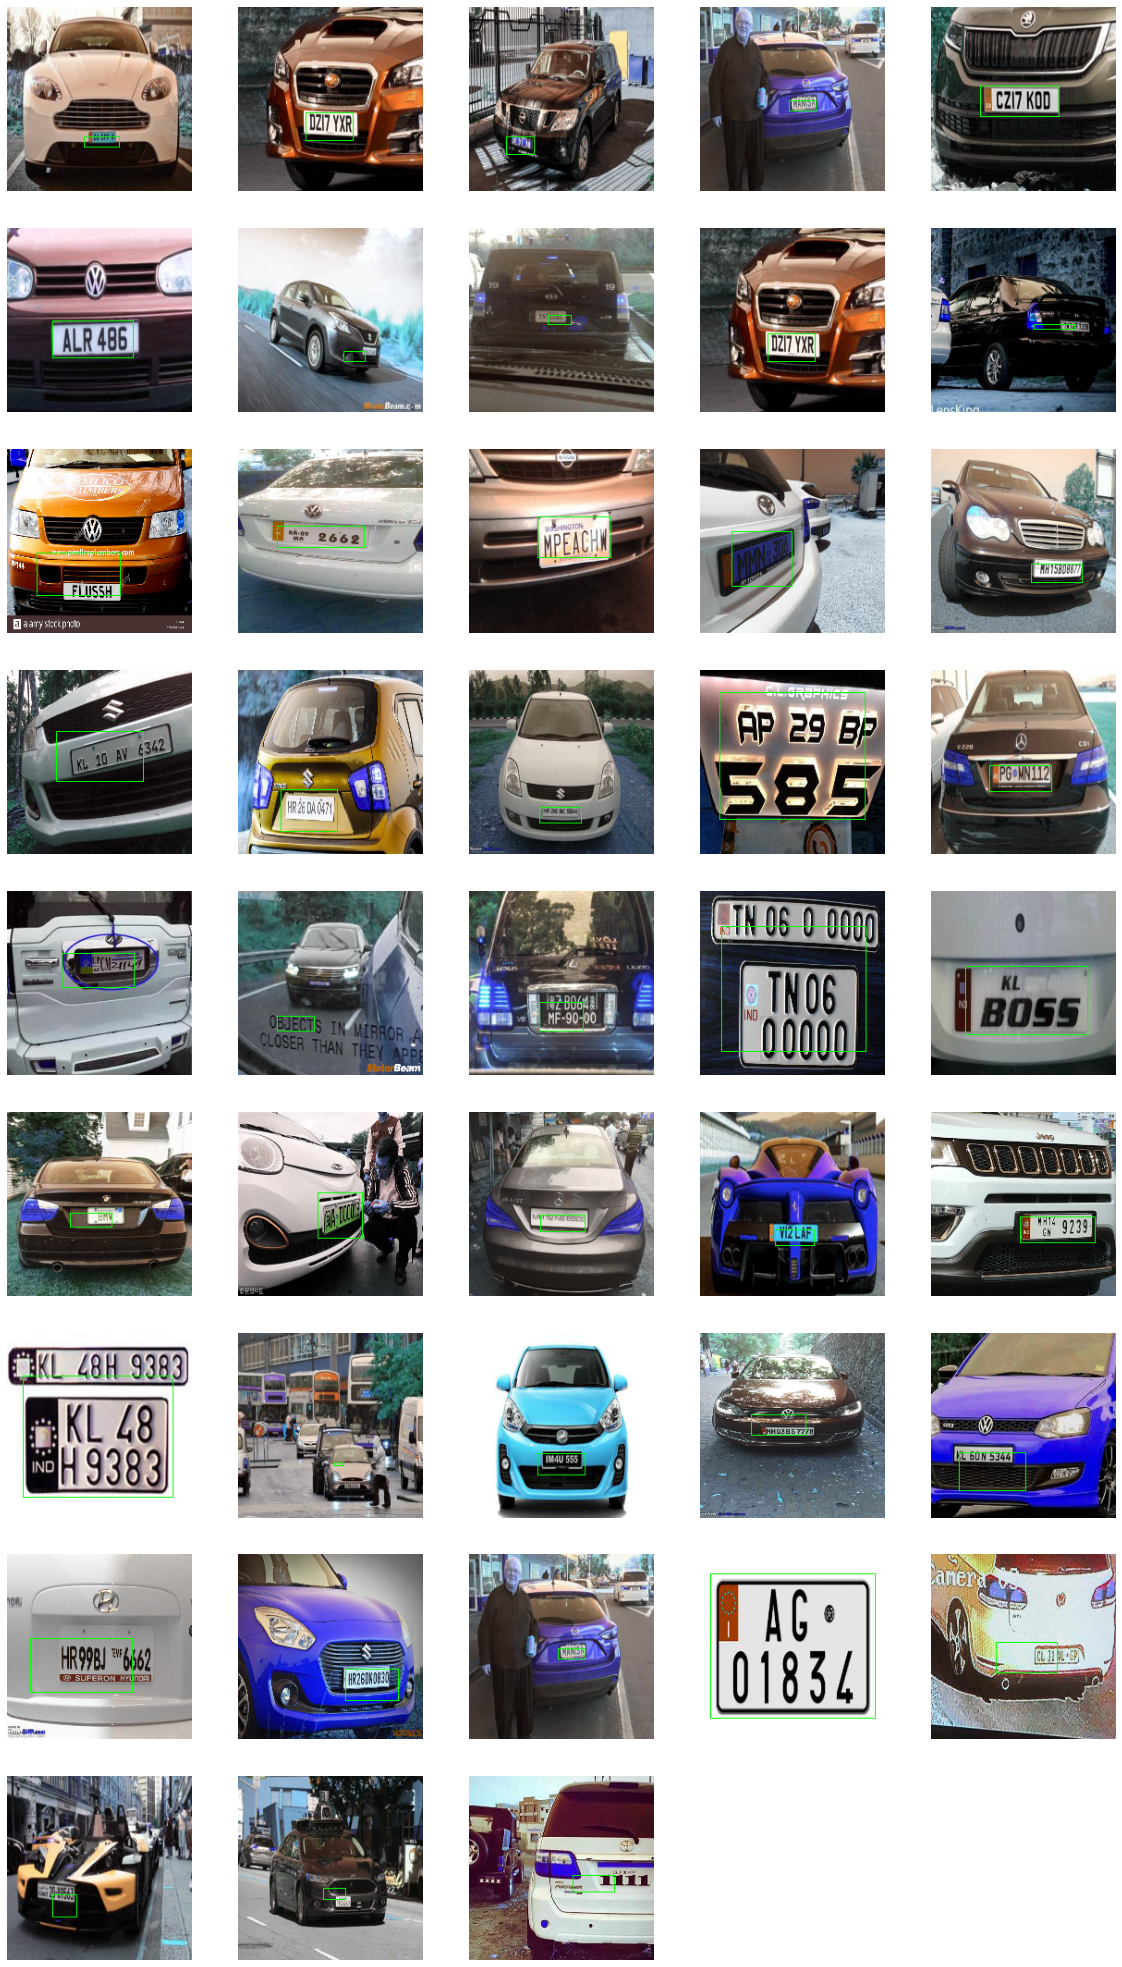

In [33]:
plt.figure(figsize=(20,40))
for i in range(0,43) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    ny = y_cnn[i]*255
    image = cv2.rectangle(X_test[i],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    plt.imshow(image)
